In [51]:
import numpy as np 
import torch 
import torch.nn as nn
from typing import List
import torch.optim as optim
import matplotlib.pyplot as plt

1. Dataset Generation

In [52]:
def generate_dataset(num_sequences, max_seq_length): # each sequence returned is a tensor of shape (seq_length, 2)
  seq_lengths = (torch.randint(size=(num_sequences,), low=1, high=max_seq_length)).tolist()
  sequences = []
  for length in seq_lengths:
    column1 = torch.rand(int(length), 1)
    column2 = torch.randint(size=(int(length), 1), low=0, high=2)
    sequence = torch.cat((column1, column2), dim=1)
    sequences.append(sequence)
  return sequences, seq_lengths # sequences is a list of tensors, seq_lengths is a list of integers


sequences, seq_lengths = generate_dataset(50, 10)

In [53]:
def print_sequences(sequences, seq_lengths, targets=None):
  for i, seq in enumerate(sequences):
    print("Sequence", i, "\t\t length ", seq_lengths[i])
    for j in range(len(seq)):
      print(seq[j][0].item(), "\t", seq[j][1].item())
    if targets:
      print("Target:\t\t\t", targets[i].item())
    print()


print_sequences(sequences, seq_lengths)
  

Sequence 0 		 length  4
0.773616373538971 	 1.0
0.2985222339630127 	 1.0
0.7898463606834412 	 0.0
0.4790148138999939 	 0.0

Sequence 1 		 length  1
0.31692349910736084 	 1.0

Sequence 2 		 length  5
0.5113587379455566 	 0.0
0.5154709815979004 	 0.0
0.06948262453079224 	 1.0
0.5258159637451172 	 0.0
0.32026898860931396 	 1.0

Sequence 3 		 length  4
0.9362121224403381 	 0.0
0.4591791033744812 	 0.0
0.2897356152534485 	 0.0
0.7200269103050232 	 0.0

Sequence 4 		 length  3
0.28884100914001465 	 1.0
0.5647660493850708 	 1.0
0.8609097599983215 	 1.0

Sequence 5 		 length  9
0.3031598925590515 	 0.0
0.14482295513153076 	 1.0
0.30613183975219727 	 0.0
0.47397148609161377 	 0.0
0.6818090677261353 	 1.0
0.339341938495636 	 1.0
0.20422577857971191 	 1.0
0.27944689989089966 	 1.0
0.5519023537635803 	 1.0

Sequence 6 		 length  9
0.4963182210922241 	 0.0
0.30994629859924316 	 1.0
0.8833398818969727 	 1.0
0.6418948173522949 	 0.0
0.5040497779846191 	 0.0
0.11848372220993042 	 1.0
0.616099238395690

In [54]:
def get_targets(sequences):
  targets = [torch.sum(torch.mul(seq[:, 0], seq[:, 1])) for seq in sequences]
  return targets

sequences, seq_lengths = generate_dataset(100, 10)
targets = get_targets(sequences)
print_sequences(sequences=sequences, seq_lengths=seq_lengths, targets=targets)

Sequence 0 		 length  8
0.8858638405799866 	 0.0
0.9735357165336609 	 1.0
0.6965543627738953 	 1.0
0.14921188354492188 	 1.0
0.7343566417694092 	 0.0
0.2648094892501831 	 1.0
0.04544985294342041 	 1.0
0.2514442205429077 	 1.0
Target:			 2.3810057640075684

Sequence 1 		 length  6
0.7193614840507507 	 0.0
0.05774688720703125 	 1.0
0.5799925327301025 	 0.0
0.3554760813713074 	 0.0
0.37955236434936523 	 1.0
0.5532270669937134 	 1.0
Target:			 0.9905263185501099

Sequence 2 		 length  5
0.21745657920837402 	 1.0
0.9095516204833984 	 1.0
0.8659935593605042 	 1.0
0.24561560153961182 	 1.0
0.5496479272842407 	 0.0
Target:			 2.238617420196533

Sequence 3 		 length  9
0.5179160833358765 	 0.0
0.7194818258285522 	 0.0
0.40351641178131104 	 0.0
0.4682512879371643 	 1.0
0.5391340255737305 	 0.0
0.3268733620643616 	 1.0
0.7985407710075378 	 0.0
0.1906498670578003 	 0.0
0.794625997543335 	 0.0
Target:			 0.7951246500015259

Sequence 4 		 length  4
0.05582147836685181 	 0.0
0.16199713945388794 	 0.0

In [110]:
sequences, seq_lengths = generate_dataset(5000, 10)
training_sequences = sequences[:3000]
test_sequences = sequences[3000:]
targets = get_targets(sequences)
training_targets = targets[:3000]
test_targets = targets[3000:]

2. Elman Implementation

In [111]:
class ElmanRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(ElmanRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.Wxh = nn.Parameter(torch.randn(input_size, hidden_size))
    self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size))
    self.Why = nn.Parameter(torch.randn(hidden_size, output_size))
    
    self.bh = nn.Parameter(torch.zeros(hidden_size))
    self.by = nn.Parameter(torch.zeros(output_size))
  
  def forward(self, x): # x is a tensor of shape (seq_length, input_size) i.e. a single sequence
    seq_len = x.shape[0]
    h = torch.zeros((1, self.hidden_size))
    output = torch.zeros((1, self.output_size))
    for t in range(seq_len):
      h = torch.sigmoid(torch.matmul(x[t], self.Wxh) + torch.matmul(h, self.Whh) + self.bh)
      y = torch.matmul(h, self.Why) + self.by
      output += y
    return output
    

In [104]:
def train(model: nn.Module, epochs:int, sequences: List[torch.Tensor], targets: List[torch.Tensor], optimizer: optim.Optimizer, loss_fn: nn.Module):
  model.train()
  losses = []
  for e in range(epochs):
    predictions = []
    for i, seq in enumerate(sequences):
      model.zero_grad()
      pred = model(seq).squeeze()
      predictions.append(pred)
      # nn.utils.clip_grad_norm_(model.parameters(), 5)
    loss = loss_fn(torch.stack(predictions), torch.stack(targets))
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
  return losses


In [112]:
elman = ElmanRNN(input_size=2, hidden_size=10, output_size=1)
losses = train(model=elman, epochs=100, sequences=training_sequences, targets=training_targets, optimizer=optim.Adam(elman.parameters(), lr=0.01), loss_fn=nn.MSELoss())

In [113]:
print(type(losses))

<class 'list'>


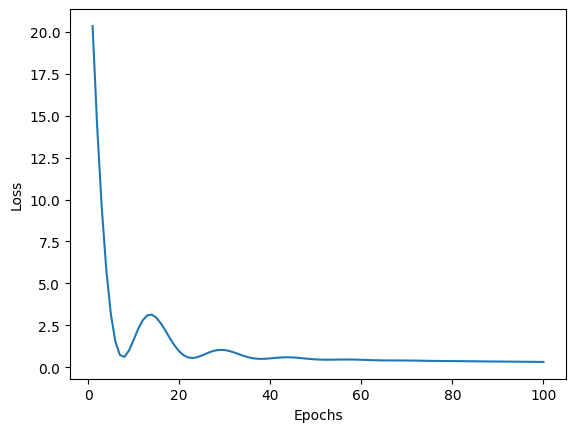

In [114]:
x = torch.arange(1, len(losses)+1)
y = torch.stack(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x.detach(), y.detach())

3. LSTM Implementation

In [115]:
class LSTMRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.Wx = nn.Parameter(torch.randn(input_size, 4*hidden_size))
    self.Wh = nn.Parameter(torch.randn(hidden_size, 4*hidden_size))
    self.Wy = nn.Parameter(torch.randn(hidden_size, output_size))
    
    self.b = nn.Parameter(torch.zeros(4*hidden_size))
    self.by = nn.Parameter(torch.zeros(output_size))
  
  def forward(self, x): # x is a tensor of shape (seq_length, input_size) i.e. a single sequence
    seq_len = x.shape[0]
    h = torch.zeros((1, self.hidden_size))
    c = torch.zeros((1, self.hidden_size))
    output = torch.zeros((1, self.output_size))
    for t in range(seq_len):
      gates = torch.matmul(x[t], self.Wx) + torch.matmul(h, self.Wh) + self.b
      gates = torch.sigmoid(gates)
      i, f, o, g = gates.chunk(4, dim=1)
      c = torch.mul(f, c) + torch.mul(i, g)
      h = torch.mul(o, torch.tanh(c))
      y = torch.matmul(h, self.Wy) + self.by
      output += y
    return output

In [ ]:
# class LSTMRNN(nn.Module):
#   def __init(self, input_size, hidden_size, output_size):
#     self.input_size = input_size
#     self.hidden_size = hidden_size
#     self.output_size = output_size
  


In [116]:
lstm = LSTMRNN(input_size=2, hidden_size=10, output_size=1)
losses2 = train(model=lstm, epochs=100, sequences=training_sequences, targets=training_targets, optimizer=optim.Adam(lstm.parameters(), lr=0.01), loss_fn=nn.MSELoss())

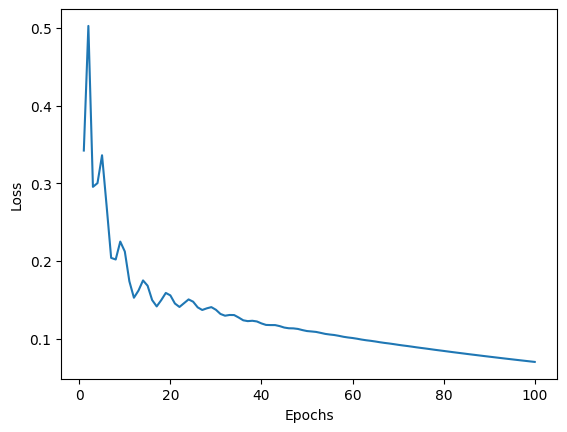

In [117]:
x = torch.arange(1, len(losses2)+1)
y = torch.stack(losses2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x.detach(), y.detach())

4. GRU Implementation

In [64]:
class GRURNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRURNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.Wx = nn.Parameter(torch.randn(input_size, 3*hidden_size))
    self.Wh = nn.Parameter(torch.randn(hidden_size, 3*hidden_size))
    self.Wy = nn.Parameter(torch.randn(hidden_size, output_size))
    
    self.b = nn.Parameter(torch.zeros(3*hidden_size))
    self.by = nn.Parameter(torch.zeros(output_size))
  
  def forward(self, x): # x is a tensor of shape (seq_length, input_size) i.e. a single sequence
    seq_len = x.shape[0]
    h = torch.zeros((1, self.hidden_size))
    output = torch.zeros((1, self.output_size))
    for t in range(seq_len):
      gates = torch.matmul(x[t], self.Wx) + torch.matmul(h, self.Wh) + self.b
      gates = torch.sigmoid(gates)
      r, z, n = gates.chunk(3, dim=1)
      h = torch.mul(r, h)
      h = torch.mul(z, h) + torch.mul(1-z, n)
      y = torch.matmul(h, self.Wy) + self.by
      output += y
    return output

In [118]:
gru = GRURNN(input_size=2, hidden_size=10, output_size=1)
losses3 = train(model=gru, epochs=100, sequences=training_sequences, targets=training_targets, optimizer=optim.Adam(gru.parameters(), lr=0.01), loss_fn=nn.MSELoss())


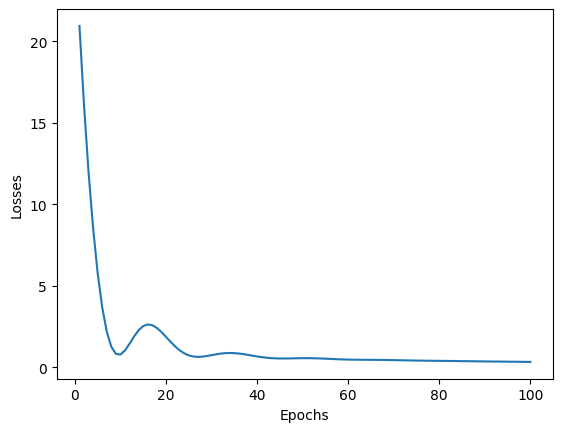

In [66]:
x = torch.arange(1, len(losses3)+1)
y = torch.stack(losses3)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(x.detach(), y.detach())

5. Testing

In [67]:
def test(model: nn.Module, sequences: List[torch.Tensor]):
  model.eval()
  predictions = []
  for i, seq in enumerate(sequences):
    pred = model(seq).squeeze()
    predictions.append(pred)
  return predictions

elman_preds = test(model=elman, sequences=test_sequences)
lstm_preds = test(model=lstm, sequences=test_sequences)
gru_preds = test(model=gru, sequences=test_sequences)

In [89]:
def plot_predictions(predictions, targets):
  x = torch.arange(1, len(predictions)+1)
  y = torch.stack(predictions)
  plt.xlabel("Sequence")
  plt.ylabel("Value")
  plt.plot(x.detach(), y.detach(), label="Predictions")
  plt.plot(x.detach(), targets, label="Targets")
  plt.legend()
  plt.show()

6. Baseline

7. Comparing Learning Curves

8. Comparing Test Performance